<a href="https://colab.research.google.com/github/EsaAlliant2/Pengelohan-Citra-Digital/blob/main/Pertemuan7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

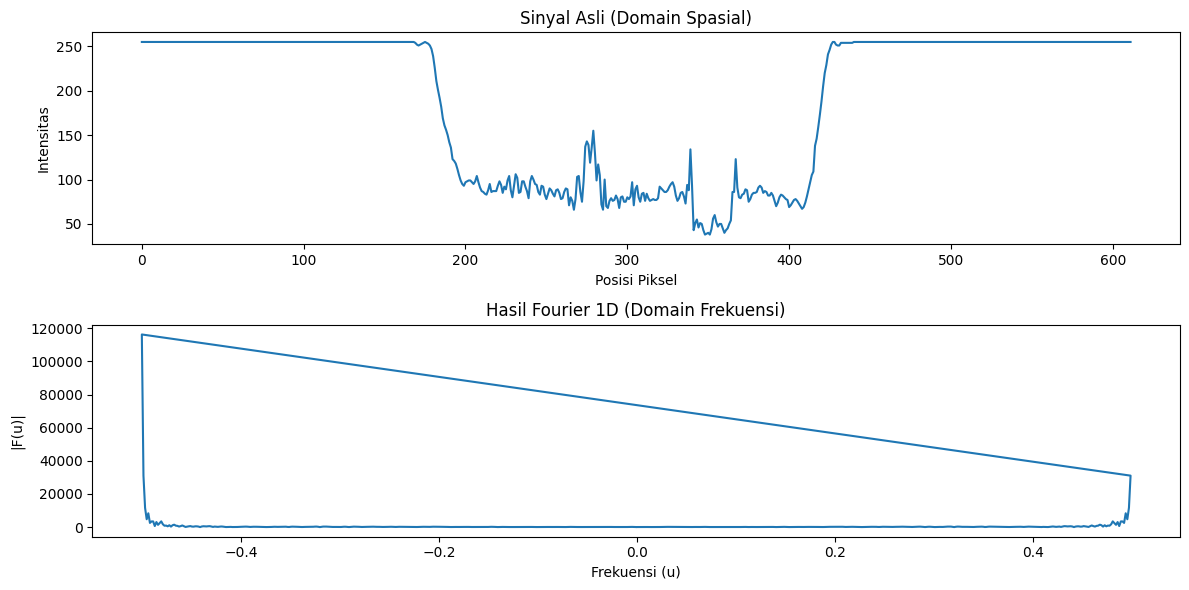

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Baca gambar grayscale
img = cv2.imread('Semester7/tomat_grayscale.jpg', 0)

# 2. Ambil satu baris (misal baris ke-100) sebagai sinyal 1D
row = img[100, :]   # sinyal spasial 1D

# 3. Lakukan Fourier Transform 1D
F = np.fft.fft(row)
Fshift = np.fft.fftshift(F)

# 4. Hitung magnitude spectrum
magnitude = np.abs(Fshift)
freq = np.fft.fftfreq(len(row))

# 5. Tampilkan hasil
plt.figure(figsize=(12,6))


plt.subplot(2,1,1)
plt.plot(row)
plt.title('Sinyal Asli (Domain Spasial)')
plt.xlabel('Posisi Piksel')
plt.ylabel('Intensitas')

plt.subplot(2,1,2)
plt.plot(freq, magnitude)
plt.title('Hasil Fourier 1D (Domain Frekuensi)')
plt.xlabel('Frekuensi (u)')
plt.ylabel('|F(u)|')
plt.tight_layout()
plt.show()


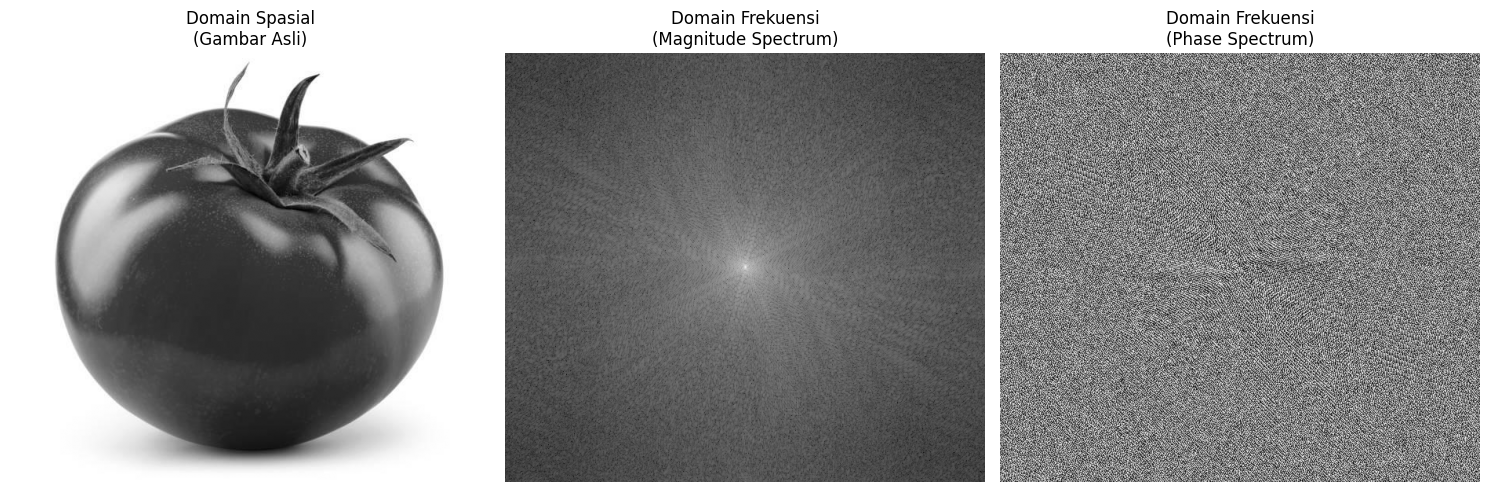

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def spatial_to_frequency_2d(image_path):
    """
    Mengubah gambar dari domain spasial ke domain frekuensi menggunakan FFT 2D
    """
    # Baca gambar dan konversi ke grayscale
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Lakukan FFT 2D
    fft_result = np.fft.fft2(gray)

    # Shift nol frekuensi ke tengah
    fft_shifted = np.fft.fftshift(fft_result)

    # Hitung magnitude spectrum (dalam skala log untuk visualisasi)
    magnitude_spectrum = np.log(1 + np.abs(fft_shifted))

    # Hitung phase spectrum
    phase_spectrum = np.angle(fft_shifted)

    return gray, fft_result, fft_shifted, magnitude_spectrum, phase_spectrum

def plot_2d_fourier_results(original, magnitude_spectrum, phase_spectrum):
    """
    Plot hasil transformasi Fourier 2D
    """
    plt.figure(figsize=(15, 5))

    # Plot gambar asli
    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Domain Spasial\n(Gambar Asli)')
    plt.axis('off')

    # Plot magnitude spectrum
    plt.subplot(1, 3, 2)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Domain Frekuensi\n(Magnitude Spectrum)')
    plt.axis('off')

    # Plot phase spectrum
    plt.subplot(1, 3, 3)
    plt.imshow(phase_spectrum, cmap='gray')
    plt.title('Domain Frekuensi\n(Phase Spectrum)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Contoh penggunaan
if __name__ == "__main__":
    image_path = "Semester7/tomat_grayscale.jpg"  # Ganti dengan path gambar Anda

    try:
        original, fft_result, fft_shifted, magnitude_spectrum, phase_spectrum = spatial_to_frequency_2d(image_path)
        plot_2d_fourier_results(original, magnitude_spectrum, phase_spectrum)

    except Exception as e:
        print(f"Error: {e}")
        print("Pastikan path gambar benar dan gambar tersedia")

#Menghilangkan noise dengan low filter


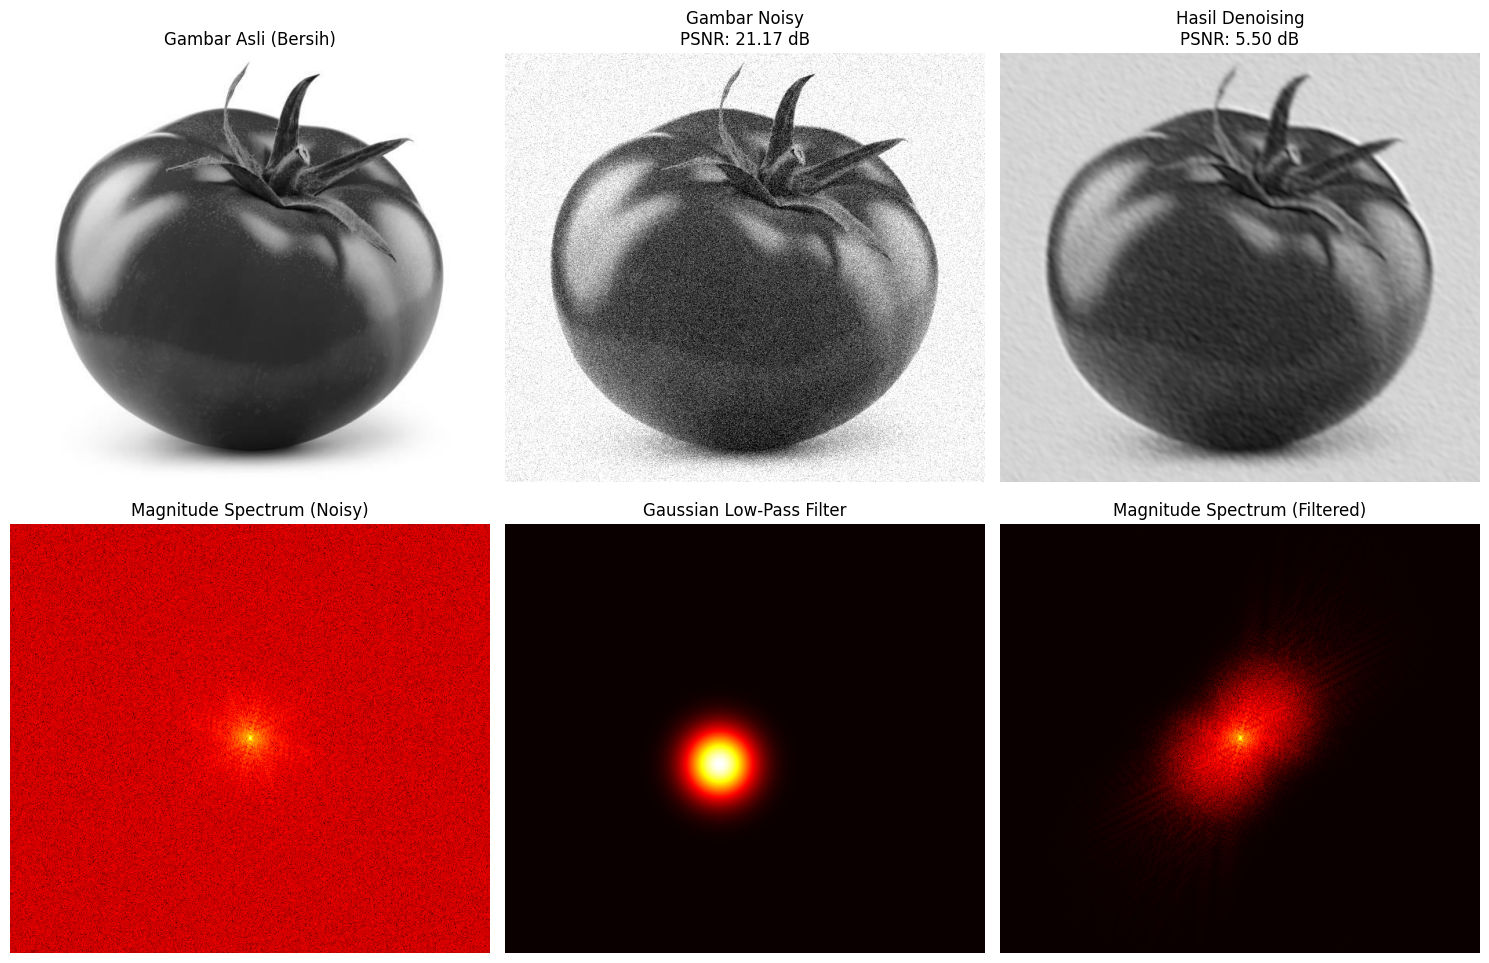

PSNR Noisy: 21.17 dB
PSNR Filtered: 5.50 dB
Improvement: -15.67 dB


In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def remove_noise_gaussian(image_path, cutoff_freq=30):
    """
    Menghilangkan noise dengan Gaussian Low-Pass Filter di domain frekuensi
    """
    # Baca gambar dan konversi ke grayscale
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Normalisasi gambar
    gray = gray.astype(np.float32) / 255.0

    # Tambahkan noise Gaussian untuk demonstrasi (jika gambar sudah bersih)
    noisy = add_gaussian_noise(gray)

    # Transformasi Fourier 2D
    fft_noisy = np.fft.fft2(noisy)
    fft_shifted = np.fft.fftshift(fft_noisy)

    # Buat Gaussian Low-Pass Filter
    rows, cols = gray.shape
    crow, ccol = rows//2, cols//2
    gaussian_filter = create_gaussian_filter(rows, cols, crow, ccol, cutoff_freq)

    # Apply filter
    filtered_fft = fft_shifted * gaussian_filter

    # Inverse FFT
    fft_ishift = np.fft.ifftshift(filtered_fft)
    img_filtered = np.fft.ifft2(fft_ishift)
    img_filtered = np.abs(img_filtered)

    # Hitung PSNR untuk evaluasi
    psnr_noisy = calculate_psnr(gray, noisy)
    psnr_filtered = calculate_psnr(gray, img_filtered)

    return gray, noisy, img_filtered, gaussian_filter, psnr_noisy, psnr_filtered

def add_gaussian_noise(image, mean=0, sigma=0.1):
    """Menambahkan Gaussian noise untuk demonstrasi"""
    noise = np.random.normal(mean, sigma, image.shape)
    noisy = image + noise
    return np.clip(noisy, 0, 1)

def create_gaussian_filter(rows, cols, center_x, center_y, cutoff_freq):
    """Membuat Gaussian Low-Pass Filter"""
    x = np.arange(0, cols)
    y = np.arange(0, rows)
    X, Y = np.meshgrid(x, y)

    # Hitung distance dari center
    distance = np.sqrt((X - center_x)**2 + (Y - center_y)**2)

    # Gaussian filter
    gaussian_filter = np.exp(-(distance**2) / (2 * (cutoff_freq**2)))
    return gaussian_filter

def calculate_psnr(original, processed):
    """Menghitung PSNR antara gambar original dan processed"""
    mse = np.mean((original - processed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def plot_denoising_results(original, noisy, filtered, filter_mask, psnr_noisy, psnr_filtered):
    """Plot hasil denoising"""
    plt.figure(figsize=(15, 10))

    # Plot gambar asli
    plt.subplot(2, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Gambar Asli (Bersih)')
    plt.axis('off')

    # Plot gambar noisy
    plt.subplot(2, 3, 2)
    plt.imshow(noisy, cmap='gray')
    plt.title(f'Gambar Noisy\nPSNR: {psnr_noisy:.2f} dB')
    plt.axis('off')

    # Plot gambar hasil filter
    plt.subplot(2, 3, 3)
    plt.imshow(filtered, cmap='gray')
    plt.title(f'Hasil Denoising\nPSNR: {psnr_filtered:.2f} dB')
    plt.axis('off')

    # Plot magnitude spectrum noisy
    fft_noisy = np.fft.fftshift(np.fft.fft2(noisy))
    magnitude_noisy = np.log(1 + np.abs(fft_noisy))

    plt.subplot(2, 3, 4)
    plt.imshow(magnitude_noisy, cmap='hot')
    plt.title('Magnitude Spectrum (Noisy)')
    plt.axis('off')

    # Plot filter
    plt.subplot(2, 3, 5)
    plt.imshow(filter_mask, cmap='hot')
    plt.title('Gaussian Low-Pass Filter')
    plt.axis('off')

    # Plot magnitude spectrum filtered
    fft_filtered = np.fft.fftshift(np.fft.fft2(filtered))
    magnitude_filtered = np.log(1 + np.abs(fft_filtered))

    plt.subplot(2, 3, 6)
    plt.imshow(magnitude_filtered, cmap='hot')
    plt.title('Magnitude Spectrum (Filtered)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Contoh penggunaan
if __name__ == "__main__":
    image_path = "Semester7/tomat_grayscale.jpg"  # Ganti dengan path gambar Anda

    try:
        original, noisy, filtered, filter_mask, psnr_noisy, psnr_filtered = remove_noise_gaussian(image_path, cutoff_freq=30)
        plot_denoising_results(original, noisy, filtered, filter_mask, psnr_noisy, psnr_filtered)

        print(f"PSNR Noisy: {psnr_noisy:.2f} dB")
        print(f"PSNR Filtered: {psnr_filtered:.2f} dB")
        print(f"Improvement: {psnr_filtered - psnr_noisy:.2f} dB")

    except Exception as e:
        print(f"Error: {e}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')